#### [학습에 필요한 모듈 선언]

In [1]:
import tensorflow as tf
import pandas as pd
from sklearn.utils import shuffle
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import os
# requests import error 발생시  pip install requests 로 설치
import requests

#### [환경설정]

In [2]:
# 학습 데이터(훈련/테스트) 비율
trainDataRate = 0.7
# 학습률
learningRate = 0.01
# 총 학습 횟수
totalStep = 10001
# 데이터 섞기
shuffleOn = True
# 학습 데이터 파일명 지정
fileName = "IrisData.csv"
# 학습 데이터 경로 지정
currentFolderPath = os.getcwd()
dataSetFolderPath = os.path.join(currentFolderPath, 'dataset')
datasetFilePath = os.path.join(dataSetFolderPath, fileName)

#### [빌드단계] Step 1) 학습 데이터 준비

===== Data =====>
     sepalLength  sepalWidth  petalLength  petalWidth          species
74           6.4         2.9          4.3         1.3  Iris-versicolor
64           5.6         2.9          3.6         1.3  Iris-versicolor
12           4.8         3.0          1.4         0.1      Iris-setosa
24           4.8         3.4          1.9         0.2      Iris-setosa
147          6.5         3.0          5.2         2.0   Iris-virginica
     sepalLength  sepalWidth  petalLength  petalWidth          species
61           5.9         3.0          4.2         1.5  Iris-versicolor
128          6.4         2.8          5.6         2.1   Iris-virginica
72           6.3         2.5          4.9         1.5  Iris-versicolor
48           5.3         3.7          1.5         0.2      Iris-setosa
0            5.1         3.5          1.4         0.2      Iris-setosa
Shape : (150, 5)
Specis : 
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: species, dtype: int64


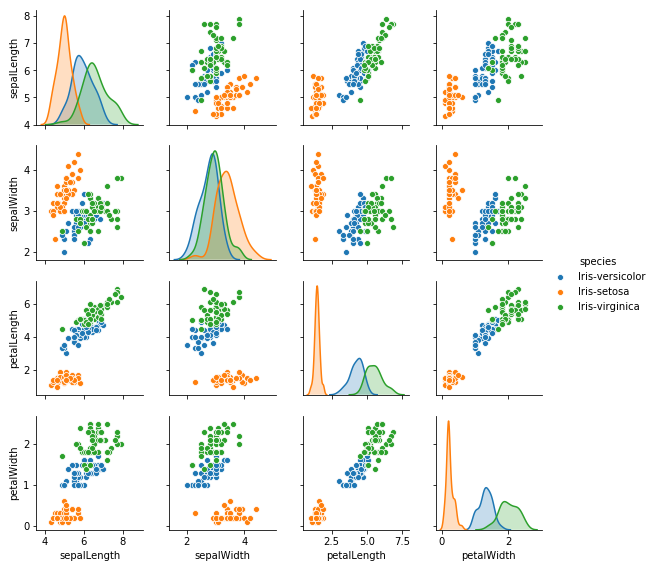

In [3]:
### (1) 데이터 읽어오기
# 해당 경로에 학습 데이터가 없으면 다운로드
if os.path.exists(datasetFilePath) is not True:
    print("#===== Download Iris Data =====#")
    # iris 데이터 셋 다운로드
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
    req = requests.get(url, allow_redirects = True)
    # 학습데이터 저장
    open(datasetFilePath, "wb").write(req.content)
    print("#===== Download Completed =====#")

# pandas를 이용하여 CSV 파일 데이터 읽기
allColumnName = ["sepalLength","sepalWidth","petalLength","petalWidth","species"]
# column이 없는 데이터라서 파일을 읽어올때 header 를 생성하지 않고 column을 추가
if shuffleOn :
    df = shuffle(pd.read_csv(datasetFilePath, header = None, names = allColumnName))
else :
    df = pd.read_csv(datasetFilePath, header = None, names = allColumnName)


# 학습 데이터 확인
print("===== Data =====>")
print(df.head())
print(df.tail())
# 학습 데이터 shape 확인
print("Shape : {}".format(df.shape))
# 학습 데이터 결과 갯수 확인
print("Specis : \n{}".format(df["species"].value_counts()))


# 학습 데이터 전체 그래프
sns.pairplot(df, hue="species", height = 2)
plt.show()


In [4]:
### (2) 범주형 데이터 맴핑 선언
# species 를 3가지 종류로 나눈 dataframe 으로 변환
df_one_hot_encoded = pd.get_dummies(df)

print("===== after mapping =====>")
print(df_one_hot_encoded.head())
print(df_one_hot_encoded.tail())


===== after mapping =====>
     sepalLength  sepalWidth  petalLength  petalWidth  species_Iris-setosa  \
74           6.4         2.9          4.3         1.3                    0   
64           5.6         2.9          3.6         1.3                    0   
12           4.8         3.0          1.4         0.1                    1   
24           4.8         3.4          1.9         0.2                    1   
147          6.5         3.0          5.2         2.0                    0   

     species_Iris-versicolor  species_Iris-virginica  
74                         1                       0  
64                         1                       0  
12                         0                       0  
24                         0                       0  
147                        0                       1  
     sepalLength  sepalWidth  petalLength  petalWidth  species_Iris-setosa  \
61           5.9         3.0          4.2         1.5                    0   
128          6.4  

In [5]:
### (3) 훈련, 테스트 데이터 나누기
# 학습 데이터 리스트로 변환
# 훈련 데이터를 정해진 비율만큼 추출
df_trainData = df_one_hot_encoded.sample(frac = trainDataRate)

# 훈련 데이터를 제거한 나머지 데이터를 테스트 테이터로 지정
df_testData = df_one_hot_encoded.drop(df_trainData.index)

# 학습데이터와 결과데이터의 컬럼 선언
featureColumnName = ["sepalLength","sepalWidth","petalLength","petalWidth"]
resultColumnName = ['species_Iris-setosa','species_Iris-versicolor','species_Iris-virginica']
# 학습데이터 선언
xTrainDataList = df_trainData.filter(featureColumnName)
yTrainDataList = df_trainData.filter(resultColumnName)
# 테스트 데이터 선언
xTestDataList = df_testData.filter(featureColumnName)
yTestDataList = df_testData.filter(resultColumnName)

print("[TrainData Size] x : {}, y :{}".format(len(xTrainDataList),len(yTrainDataList)))
print("[TestData Size] x : {}, y :{}".format(len(xTestDataList),len(yTestDataList)))

[TrainData Size] x : 105, y :105
[TestData Size] x : 45, y :45


#### [빌드단계] Step 2) 모델 생성을 위한 변수 초기화

In [6]:
# feature 로 사용할 데이터 갯수
feature_num = len(featureColumnName)
# result 로 사용할 종류 갯수
result_num = len(resultColumnName)

# 학습데이터가 들어갈 플레이스 홀더 선언
X = tf.placeholder(tf.float32, shape = [None, feature_num])
# 학습데이터가 들어갈 플레이스 홀더 선언
Y = tf.placeholder(tf.float32, shape = [None, result_num])


# Weight 변수 선언
W = tf.Variable(tf.zeros([feature_num, result_num]))
# Bias 변수 선언
b = tf.Variable(tf.zeros([result_num]))

#### [빌드단계] 3) 학습 모델 그래프 구성

In [7]:
# 3-1) 학습데이터를 대표 하는 가설 그래프 선언
hypothesis = tf.nn.softmax(tf.matmul(X, W) + b)

# 3-2) 비용함수(오차함수,손실함수) 선언
costFunction = tf.reduce_mean(-tf.reduce_sum(Y * tf.log(hypothesis), axis=1))

# 3-3) 비용함수의 값이 최소가 되도록 하는 최적화함수 선언
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learningRate)
train = optimizer.minimize(costFunction)

#### [실행단계] 학습 모델 그래프를 실행

--------------------------------------------------------------------------------
Train(Optimization) Start 
step : 0. cost : 1.0986120700836182, accuracy : 0.32380953431129456
step : 1000. cost : 0.36039018630981445, accuracy : 0.9809523820877075
step : 2000. cost : 0.26915720105171204, accuracy : 0.9809523820877075
step : 3000. cost : 0.2208649069070816, accuracy : 0.9809523820877075
step : 4000. cost : 0.19072110950946808, accuracy : 0.9809523820877075
step : 5000. cost : 0.17003555595874786, accuracy : 0.9809523820877075
step : 6000. cost : 0.15490441024303436, accuracy : 0.9809523820877075
step : 7000. cost : 0.14331701397895813, accuracy : 0.9809523820877075
step : 8000. cost : 0.13413304090499878, accuracy : 0.9809523820877075
step : 9000. cost : 0.1266573965549469, accuracy : 0.9809523820877075
step : 10000. cost : 0.1204414889216423, accuracy : 0.9809523820877075
W : [[ 0.8201963   1.0014926  -1.8216825 ]
 [ 2.0526862  -0.5967354  -1.455941  ]
 [-2.7249358  -0.16258968  2.88750

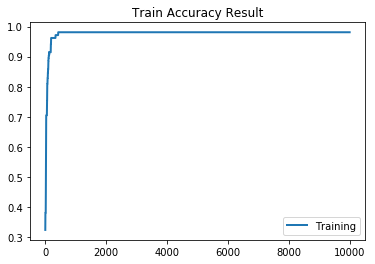

Train Finished
--------------------------------------------------------------------------------
[Test Result]

Hypothesis : [[6.33650720e-02 9.12721336e-01 2.39135493e-02]
 [9.82990742e-01 1.70092750e-02 2.45969325e-08]
 [3.19021521e-03 9.00789082e-01 9.60207060e-02]
 [9.92245257e-01 7.75472913e-03 8.66597816e-09]
 [8.53420258e-01 1.46577537e-01 2.26711768e-06]
 [4.94950917e-03 5.40873647e-01 4.54176843e-01]
 [6.48018522e-06 8.89336914e-02 9.11059856e-01]
 [9.83135641e-01 1.68643035e-02 3.03607770e-08]
 [3.81634082e-03 4.02192116e-01 5.93991578e-01]
 [7.80943139e-07 5.73790185e-02 9.42620218e-01]
 [1.86301149e-05 9.23678949e-02 9.07613516e-01]
 [8.27683834e-07 2.01106770e-03 9.97988105e-01]
 [3.21161206e-05 5.33541888e-02 9.46613729e-01]
 [9.83758748e-01 1.62410773e-02 1.83246769e-07]
 [1.61715998e-05 2.59430707e-02 9.74040806e-01]
 [9.91442144e-01 8.55784956e-03 1.87250015e-09]
 [1.43013618e-04 5.79874277e-01 4.19982702e-01]
 [9.65882540e-01 3.41172181e-02 2.45865948e-07]
 [1.96525943

In [8]:
# 실행을 위한 세션 선언
sess = tf.Session()
# 최적화 과정을 통하여 구해질 변수 W,b 초기화
sess.run(tf.global_variables_initializer())

# 예측값, 정확도 수식 선언
predicted = tf.equal(tf.argmax(hypothesis, axis = 1), tf.argmax(Y, axis =1))
accuracy = tf.reduce_mean(tf.cast(predicted, tf.float32))

# 학습, 테스트 정확도를 저장할 리스트 선언
train_accuracy = list()


print("--------------------------------------------------------------------------------")
print("Train(Optimization) Start ")

for step in range(totalStep):
    # X, Y에 학습데이터 입력하여 비용함수, W, b, accuracy, train을 실행
    cost_val, W_val, b_val, acc_val, _ = sess.run([costFunction, W, b, accuracy, train],
                                            feed_dict = {X: xTrainDataList, Y: yTrainDataList})
    train_accuracy.append(acc_val)

    if step % 1000 == 0:
        print("step : {}. cost : {}, accuracy : {}"
              .format(step, cost_val, acc_val))

    if step == totalStep-1 :
        print("W : {}\nb:{}".format(W_val, b_val))


# matplotlib 를 이용하여 결과를 시각화
# 정확도 결과 확인 그래프
plt.plot(range(len(train_accuracy)), train_accuracy, linewidth = 2, label = 'Training')
plt.legend()
plt.title("Train Accuracy Result")
plt.show()


print("Train Finished")
print("--------------------------------------------------------------------------------")
print("[Test Result]")
# 최적화가 끝난 학습 모델 테스트
h_val, p_val, a_val = sess.run([hypothesis, predicted, accuracy],
                    feed_dict={X: xTestDataList, Y: yTestDataList})
print("\nHypothesis : {} \nPrediction : {} \nAccuracy : {}".format(h_val,p_val,a_val))
print("--------------------------------------------------------------------------------")

#세션종료
sess.close()